# Лабораторная работа 7. Полный конвейер анализа данных

В этой работе мы построим полный конвейер анализа данных:
1. [Загрузка данных.](#1.-Загрузка-данных)
1. [Изучение данных.](#2.-Изучение-данных)
1. [Предобработка данных.](#3.-Предобработка-данных)
1. [Train/validation/test datasets.](#4.-Train/validation/test-datasets)
1. [Построение моделей и оценка качества.](#5.-Построение-моделей-и-оценка-качества)
1. [Предсказание на новых данных.](#6.-Предсказание-на-новых-данных)

Строить такой конвейер будем с использованием известного набора данных - про пассажиров ["Титаника"](https://ru.wikipedia.org/wiki/Титаник) (см. файлы `train.csv` и `test.csv`). Потребуется на основе признаков пассажиров предсказать, кто из них выживет при крушении.  
В конце работы мы отправим результаты предсказания в систему [Kaggle](https://www.kaggle.com/c/titanic).

## 1. Загрузка данных
__Задание 1.__  
Загрузите обучающие (`train.csv`) и тестовые (`test.csv`) данные с использованием `pandas`. Данные хранятся в файлах формата [CSV](https://ru.wikipedia.org/wiki/CSV) (Comma-Separated Values).  
Описание признаков содержится в файле `description.txt` .  
Выведите размерность обоих массивов данных.  
Обратите внимание, что в тестовых данных количество признаков меньше на единицу, чем в обучающих - отсутствует целевая переменная `Survived`. Результаты предсказания на тестовых данных будут отправляться на сервер Kaggle.

In [164]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [139]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

print(f"Размерность массива тренировочных данных - {df_train.shape}")
print(f"Размерность массива тестовых данных - {df_test.shape}")

Размерность массива тренировочных данных - (891, 12)
Размерность массива тестовых данных - (418, 11)


In [140]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [141]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## 2. Изучение данных
Важнейшим этапом анализа данных является их изучение. Всегда полезно исследовать признаки, понять их смысл, внимательно посмотреть на значения признаков для разных объектов.  
Изучите признаки в нашем примере с "Титаником" (файл `description.txt`).  
Известно, что женщины и дети имели преимущество при посадке в спасательные шлюпки. Также известно о значительном имущественном неравенстве среди пассажиров. Следовательно, признаки `Age`, `Sex` и `Pclass`, вероятно, будут иметь большое значение при предсказании.

__Задание 2.__  
Выведите информацию об обучающем наборе данных.  
    *Воспользуйтесь функциями `pandas.DataFrame.describe()` и `pandas.DataFrame.info()`*.

In [142]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [143]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


__Задание 3.__  
Выведите первые десять записей в обучающем наборе данных.

In [144]:
df_train.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [145]:
df_test.drop(columns=['Cabin', 'Name', 'Embarked', 'Ticket'], inplace=True)

df_train.drop(columns=['Cabin', 'Name', 'Embarked', 'Ticket'], inplace=True)


__Задание 4.__  
Выведите количество объектов и их относительную частоту в обучающих данных для каждого из уникальных значений для признаков `Sex` и `Pclass` .  
*Воспользуйтесь функцией* `value_counts()`.

In [146]:
def analyze_features(df, features):
    for feature in features:
        print(f"Анализ признака: {feature}")
        value_counts = df[feature].value_counts(dropna=False)  # dropna=False чтобы учитывать NaN
        print("Количество объектов:")
        print(value_counts)
        print("\nОтносительная частота:")
        print(df[feature].value_counts(normalize=True, dropna=False))
        print("-" * 30)


# Анализ признаков 'Sex' и 'Pclass'
analyze_features(df_train, ['Sex', 'Pclass'])

Анализ признака: Sex
Количество объектов:
Sex
male      577
female    314
Name: count, dtype: int64

Относительная частота:
Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64
------------------------------
Анализ признака: Pclass
Количество объектов:
Pclass
3    491
1    216
2    184
Name: count, dtype: int64

Относительная частота:
Pclass
3    0.551066
1    0.242424
2    0.206510
Name: proportion, dtype: float64
------------------------------


__Задание 5.__  
Выведите процент выживших (вероятность выживания) по полам и классам. Также нарисуйте диаграммы по этим вероятностям.  
    *Воспользуйтесь функциями `pandas.pivot_table()` и `pandas.DataFrame.plot.bar()`*.

In [147]:
sex_pivot = df_train.pivot_table(index="Sex", values="Survived")
sex_pivot

,Survived
Sex,
female,0.742038
male,0.188908


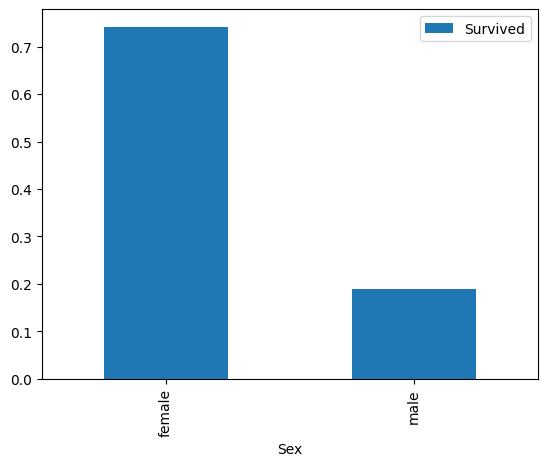

In [148]:
sex_pivot.plot.bar()
plt.show()

Вероятность выживания по полу и классу:
                Survived
Sex    Pclass          
female 1       0.968085
       2       0.921053
       3       0.500000
male   1       0.368852
       2       0.157407
       3       0.135447


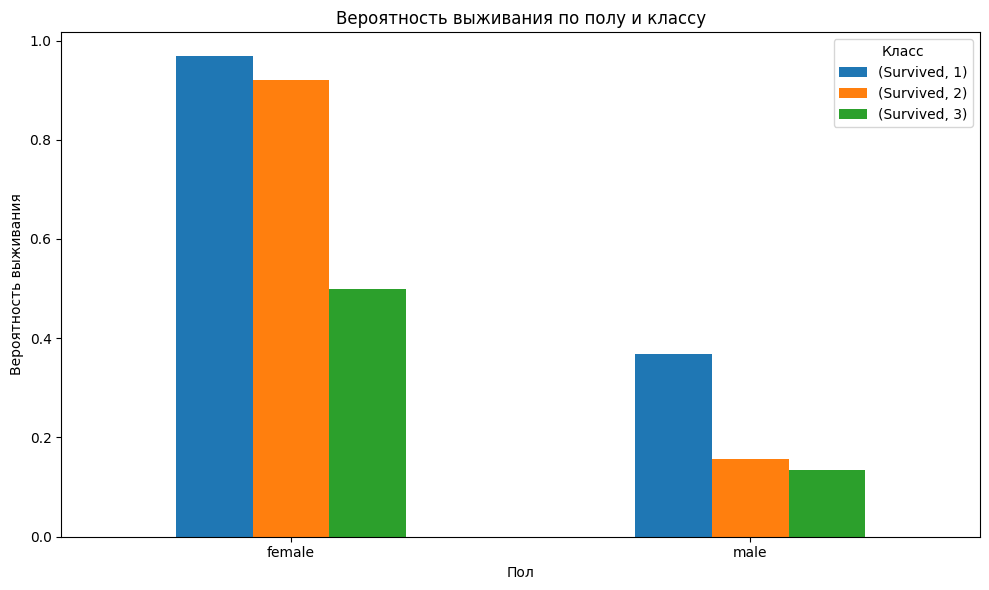

In [149]:
# Расчет вероятности выживания по полу и классу
survival_rate = pd.pivot_table(df_train, values='Survived', index=['Sex', 'Pclass'], aggfunc='mean')
print("Вероятность выживания по полу и классу:\n", survival_rate)

# Преобразование таблицы в более удобный формат для построения графика
survival_rate_unstacked = survival_rate.unstack()

# Построение столбчатой диаграммы
survival_rate_unstacked.plot.bar(figsize=(10, 6))
plt.title('Вероятность выживания по полу и классу')
plt.xlabel('Пол')
plt.ylabel('Вероятность выживания')
plt.xticks(rotation=0)
plt.legend(title='Класс')
plt.tight_layout()
plt.show()


In [150]:
# Дополнительная визуализация:  отдельные графики для каждого класса
# for pclass in survival_rate.index.get_level_values('Pclass').unique():
#     pclass_data = survival_rate.xs(pclass, level='Pclass')
#     pclass_data.plot.bar(figsize=(6,4))
#     plt.title(f"Вероятность выживания для Pclass = {pclass}")
#     plt.xlabel("Пол")
#     plt.ylabel("Вероятность выживания")
#     plt.xticks(rotation=0)
#     plt.legend().remove()
#     plt.tight_layout()
#     plt.show()

__Задание 6.__  
Выведите все уникальные значения признаков `Age`, `Sex` и `Pclass` в обучающем наборе данных.

In [151]:
print(f"Уникальные значения Age:\n{df_train['Age'].unique()}")
print(f"Уникальные значения Sex:\n{df_train['Sex'].unique()}")
print(f"Уникальные значения Pclass:\n{df_train['Pclass'].unique()}")

Уникальные значения Age:
[22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.  ]
Уникальные значения Sex:
['male' 'female']
Уникальные значения Pclass:
[3 1 2]


__Задание 7.__  
Также важно знать распределение объектов по значениям целевой переменной (`Survived`).  
Cоздайте два новых DataFrame: в первом (`survived`) будут только те объекты, у которых значение признака `Survived` равно 1, во втором (`died`) - только те объекты, у которых значение этого признака равно 0.  
Выведите количество объектов в обоих DataFrame.

In [152]:
# Создаем DataFrame survived: объекты, у которых Survived == 1
survived = df_train[df_train['Survived'] == 1]

# Создаем DataFrame died: объекты, у которых Survived == 0
died = df_train[df_train['Survived'] == 0]

# Выводим количество объектов в каждом DataFrame
print(f"Количество выживших (Survived == 1): {len(survived)}")
print(f"Количество погибших (Survived == 0): {len(died)}")

Количество выживших (Survived == 1): 342
Количество погибших (Survived == 0): 549


## 3. Предобработка данных

Признаки `Sex` и `Pclass` являются номинальными (категориальными).  
Признак `Age` является количественным.

__Задание 8.__  
Выведите статистику по признаку `Age` (воспользуйтесь функцией `describe()`).

In [153]:
df_train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Видно, что признак `Age` имеет меньше значений, чем количество объектов в обучающей выборке - это означает, что у некоторых объектов для этого признака значение пропущено (`NaN`).

Для замены пропущенных значений (NA/NaN) каким-либо определенным значением можно воспользоваться функцией `fillna()`.

Построим диаграмму зависимости выживания от возраста:

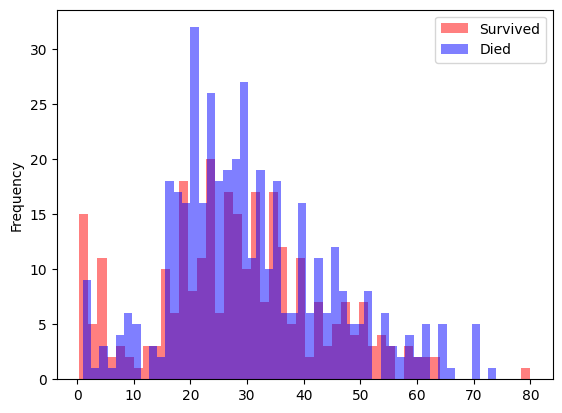

In [154]:
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

Из диаграммы видно, что для некоторых диапазонов возрастов вероятность выживания выше. Чтобы это учесть, можно преобразовать количественный признак `Age` в категориальный при помощи выделения в нем ряда диапазонов. Для этого можно воспользоваться функцией `cut()` .  
При этом необходимо помнить, что преобразования, применяемые к обучающим данным, должны быть так же применены к тестовым, иначе модели будут обучаться на данных одного вида, а тестироваться на другом виде данных.

__Задание 9.__  
Написать функцию `process_age`, которая принимает на вход `DataFrame`, границы диапазонов и названия диапазонов, а возвращает новый `DataFrame`, в котором все пропущенные значения признака `Age` заменены на `-0.5` и добавлен новый категориальный признак `Age_categories` со следующими значениями:
- "Missing" если `Age` $\in (-1, 0]$
- "Infant" если `Age` $\in (0, 5]$
- "Child" если `Age` $\in (5, 12]$
- "Teenager" если `Age` $\in (12, 18]$
- "Young_Adult" если `Age` $\in (18, 35]$
- "Adult" если `Age` $\in (35, 60]$
- "Senior" если `Age` $\in (60, 100]$

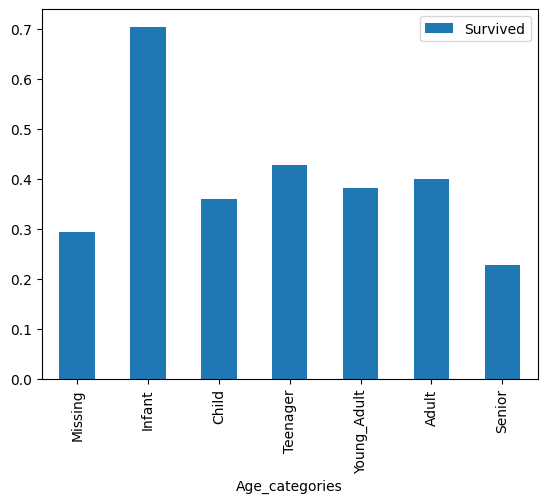

In [155]:
def process_age(df, cut_points, label_names):
    df_copy = df.copy()

    # Заменяем пропущенные значения Age на -0.5
    df_copy['Age'] = df_copy['Age'].fillna(-0.5)

    # Создаем новый признак Age_categories
    df_copy['Age_categories'] = pd.cut(df_copy['Age'], bins=cut_points, labels=label_names, right=True, include_lowest=True)

    return df_copy


cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
label_names = ["Missing", "Infant", "Child", "Teenager", "Young_Adult", "Adult", "Senior"]

train = process_age(df_train, cut_points, label_names)
test = process_age(df_test, cut_points, label_names)

age_cat_pivot = train.pivot_table(index="Age_categories", values="Survived")
age_cat_pivot.plot.bar()
plt.show()

Перед применением моделей машинного обучения следует подготовить категориальные признаки (`Sex`, `Pclass` и `Age_categories`).  
Такую подготовку следует делать, даже если значениями категориального признака являются числа [1, 2, 3], как в `Pclass`. Дело в том, что отношения между классами не соответствуют отношениям между числами, например, второй класс не в два раза "ценнее" первого класса.  

Для подготовки категориальных признаков воспользуемся *бинаризацией* (*one-hot encoding*), т.е. создадим для каждого уникального значения категориального признака новый признак (*dummy variables*). Для этого можно воспользоваться функцией `get_dummies()`.

__Задание 10.__  
Напишите функцию `create_dummies`, на вход которой поступает `DataFrame` и название признака, а на выходе возвращается `DataFrame`, дополненный новыми бинарными признаками, соответствующими уникальным значениям данного входного признака.  
Примените разработанную функцию к обучающим и тестовым данным для признаков `Sex`, `Pclass` и `Age_categories`.

In [156]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name, dtype=int)
    df_new = pd.concat([df, dummies], axis=1)
    df_new = df_new.drop(column_name, axis=1)
    return df_new


train = create_dummies(train, "Pclass")
test = create_dummies(test, "Pclass")

train = create_dummies(train, "Sex")
test = create_dummies(test, "Sex")

train = create_dummies(train, "Age_categories")
test = create_dummies(test, "Age_categories")

In [157]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PassengerId                 891 non-null    int64  
 1   Survived                    891 non-null    int64  
 2   Age                         891 non-null    float64
 3   SibSp                       891 non-null    int64  
 4   Parch                       891 non-null    int64  
 5   Fare                        891 non-null    float64
 6   Pclass_1                    891 non-null    int64  
 7   Pclass_2                    891 non-null    int64  
 8   Pclass_3                    891 non-null    int64  
 9   Sex_female                  891 non-null    int64  
 10  Sex_male                    891 non-null    int64  
 11  Age_categories_Missing      891 non-null    int64  
 12  Age_categories_Infant       891 non-null    int64  
 13  Age_categories_Child        891 non

In [158]:
train.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young_Adult,Age_categories_Adult,Age_categories_Senior
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,23.699966,0.523008,0.381594,32.204208,0.242424,0.206510,0.551066,0.352413,0.647587,0.198653,0.049383,0.028058,0.078563,0.401796,0.218855,0.024691
std,257.353842,0.486592,17.731181,1.102743,0.806057,49.693429,0.428790,0.405028,0.497665,0.477990,0.477990,0.399210,0.216787,0.165232,0.269207,0.490536,0.413702,0.155270
min,1.000000,0.000000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,6.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,24.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,668.500000,1.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [159]:
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young_Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,0,0,1,0,0
1,2,1,38.0,1,0,71.2833,1,0,0,1,0,0,0,0,0,0,1,0
2,3,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,0,0,1,0,0
3,4,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,0,0,1,0,0
4,5,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,0,0,1,0,0


## 4. Train/validation/test datasets

Для выбора моделей и подбора их параметров нужно уметь оценивать качество моделей. Чтобы вычислить метрики качества, необходимо знать правильные ответы (значения целевой переменной). Мы знаем правильные ответы для обучающего набора данных (`train`), но если мы будем оценивать качество модели на тех же данных, на которых модель обучается, это приведет к *переобучению* (*overfitting*) - ситуации, когда модель хорошо работает на известных ей данных, но имеет низкую обобщающую способность, т.е плохо предсказывает целевую переменную для новых данных.  
Поэтому качество модели оценивают с использованием *отложенной выборки* (*hold-out set*) - таких данных, для которых известны правильные ответы, но эти данные не использовались в процессе обучения.  
Есть два основных способа использования отложенной выборки:  
1. случайное разделение исходных размеченных данных на обучающую и тестовую выборки;
1. k-кратная перекрестная проверка (k-fold cross-validation).  
  
В случае, когда такие отложенные тестовые данные используются для подбора параметров моделей, их называют *валидационными* (*validation*).


__Задание 11.__  
Разделите исходную размеченную выборку на обучающую (80%) и валидационную (20%).  
Можно использовать функцию `train_test_split()` с параметром `random_state=42` .  
Выведите размерность получившихся массивов данных.

In [160]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = train.drop('Survived', axis=1)
y = train['Survived']

# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размерностей
print(f"Размерность X_train: {X_train.shape}")
print(f"Размерность X_val: {X_val.shape}")
print(f"Размерность y_train: {y_train.shape}")
print(f"Размерность y_val: {y_val.shape}")

Размерность X_train: (712, 17)
Размерность X_val: (179, 17)
Размерность y_train: (712,)
Размерность y_val: (179,)


## 5. Построение моделей и оценка качества

__Задание 12.__  
1. Обучите логистическую регрессию для предсказания целевой переменной на обучающем наборе данных.
1. Выведите значения весовых коэффициентов построенной модели.
1. Выведите значения, возвращаемые моделью (степень уверенности модели), для первых десяти примеров из обучающих данных.
1. Выведите совместно предсказания модели и истинные ответы для первых десяти примеров из обучающих данных.

In [161]:
# 1. Обучение логистической регрессии
model = LogisticRegression(max_iter=1000)  # Увеличиваем max_iter для сходимости
model.fit(X_train, y_train)

# 2. Вывод весовых коэффициентов
print("Весовые коэффициенты модели:")
print(pd.DataFrame({'feature': X_train.columns, 'coef': model.coef_[0]}))

# 3. Вывод значений, возвращаемых моделью (степень уверенности) для первых 10 примеров
probabilities = model.predict_proba(X_train[:10])
print("\nСтепень уверенности модели для первых 10 примеров:")
print(probabilities)
print("\nВероятность выжить для первых 10 примеров:")
print(probabilities[:, 1])

# 4. Вывод предсказаний модели и истинных ответов для первых 10 примеров
predictions = model.predict(X_train[:10])
print("\nПредсказания модели для первых 10 примеров:")
print(predictions)
print("\nИстинные ответы для первых 10 примеров:")
print(y_train[:10].values)

# Совместный вывод
print("\nПредсказания и истинные ответы для первых 10 примеров:")
for i in range(10):
    print(f"Пример {i+1}: Предсказание = {predictions[i]}, Истинный ответ = {y_train.values[i]}")

Весовые коэффициенты модели:
                       feature      coef
0                  PassengerId  0.000368
1                          Age -0.007266
2                        SibSp -0.402551
3                        Parch -0.286817
4                         Fare  0.005585
5                     Pclass_1  0.713984
6                     Pclass_2  0.180247
7                     Pclass_3 -0.821992
8                   Sex_female  1.438135
9                     Sex_male -1.365898
10      Age_categories_Missing -0.600801
11       Age_categories_Infant  1.828725
12        Age_categories_Child  0.297044
13     Age_categories_Teenager -0.579590
14  Age_categories_Young_Adult -0.146136
15        Age_categories_Adult -0.414613
16       Age_categories_Senior -0.312391

Степень уверенности модели для первых 10 примеров:
[[0.68234364 0.31765636]
 [0.69100183 0.30899817]
 [0.88392108 0.11607892]
 [0.90643123 0.09356877]
 [0.61977816 0.38022184]
 [0.3732957  0.6267043 ]
 [0.66736611 0.33263389]
 [0.78

__Задание 13.__  
1. Выведите значение метрики `accuracy` построенной модели логистической регрессии для обучающих и валидационных данных.
2. Выведите матрицу ошибок (*confusion matrix*) для обучающих и валидационных данных.

In [167]:
# Прогнозируем результаты для обучающей и валидационной выборок
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# Оцениваем точность (accuracy) для обеих выборок
acc_train = accuracy_score(y_train, y_pred_train)
acc_val = accuracy_score(y_val, y_pred_val)

print('Accuracy для обучающих данных:', acc_train)
print('Accuracy для валидационных данных:', acc_val)

# Конфигурация матриц ошибок
cm_train = confusion_matrix(y_train, y_pred_train)
cm_val = confusion_matrix(y_val, y_pred_val)

# Печать матриц ошибок
print('\nМатрица ошибок для обучающих данных:')
print(cm_train)

print('\nМатрица ошибок для валидационных данных:')
print(cm_val)


Accuracy для обучающих данных: 0.824438202247191
Accuracy для валидационных данных: 0.8044692737430168

Матрица ошибок для обучающих данных:
[[397  47]
 [ 78 190]]

Матрица ошибок для валидационных данных:
[[93 12]
 [23 51]]


__Задание 14.__  
Получите значения метрики `accuracy` для логистической регрессии при помощи процедуры перекрестной проверки по 10 блокам (*10-fold cross-validation*) ([Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)).  
Можно воспользоваться функциями [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) или [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) .  
Выведите значения `accuracy` для всех разбиений, а также максимум, минимум и среднее.  
Сравните полученные результаты с оценками на основе отложенной выборки.

In [169]:
# Перекрестной проверки по 10 блокам 
X = train.copy()
y = train['Survived']

model_logreg = LogisticRegression(penalty=None, fit_intercept=True, random_state=0)
cv_scores = cross_val_score(model_logreg, X, y, cv=StratifiedKFold(n_splits=10), scoring='accuracy')

print("Accuracy для каждого разбиения:")
print(cv_scores)

print("\nMax accuracy:", cv_scores.max())
print("Min accuracy:", cv_scores.min())
print("Mean accuracy:", cv_scores.mean())

# Прогнозируем результаты на основе отложенной выборки
y_pred_X = model.predict(X)

# Оцениваем точность (accuracy) на основе отложенной выборки
acc_X = accuracy_score(y, y_pred_X)

print('\nAccuracy для обучающих данных на основе отложенной выборки:', acc_X)

Accuracy для каждого разбиения:
[1.         1.         1.         0.98876404 1.         1.
 1.         1.         1.         1.        ]

Max accuracy: 1.0
Min accuracy: 0.9887640449438202
Mean accuracy: 0.9988764044943821


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Survived


__Задание 15.__  
Постройте простой базовый классификатор (*baseline*) для сравнения с моделями машинного обучения.  
Пусть базовый классификатор предсказывает выживание только женщин (вспомните соотношение выживаемости женщин и мужчин в обучающем наборе данных).  
Получите значение `accuracy` для такого классификатора на всех размеченных данных.

In [ ]:
# Ваш код здесь

## 6. Предсказание на новых данных

__Задание 16.__  
1. Обучите логистическую регрессию на всех доступных размеченных данных (`train.csv`).  
1. Получите предсказание для тестовых данных (`test.csv`).

In [ ]:
# Ваш код здесь

__Задание 17.__  
Создайте файл с результатами (*submission*) для отправки на сервер Kaggle.

In [ ]:
test_ids = test["PassengerId"]
submission_df = {"PassengerId": test_ids,
                 "Survived": test_predictions}
submission = pd.DataFrame(submission_df)

NameError: name 'test_predictions' is not defined

In [ ]:
submission.to_csv('output/titanic_submission.csv', index=False)

__Задание 18.__  
Отправьте полученный файл на сервер Kaggle.  
Для этого нужно:
1. Зарегистрироваться на [Kaggle](https://www.kaggle.com).
1. Принять участие в [соревновании](https://www.kaggle.com/c/titanic/) (*Join Competition*).
1. Отправить файл с результатами (*Submit Predictions*).  

Проверьте в таблице результатов, что ваш результат принят.